In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn import datasets
import cPickle as pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import PunktSentenceTokenizer, word_tokenize
from nltk.stem import snowball
stemmer = snowball.SnowballStemmer("english")
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline
import sys

/home/mgupta/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)
X = X.astype(np.float32)

# map labels from {-1, 1} to {0, 1}
labels, y = np.unique(y, return_inverse=True)

X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

In [3]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)

In [4]:
param = {'max_depth':2,
             'eta':0.5,
             'silent':1,
             'objective':'binary:logistic',
             'eval_metric':'auc'
             }
num_round = 5
watchlist = [(xg_train, 'train'), (xg_test, 'eval')]
results = dict()

In [5]:
model = xgb.train(param,
                  xg_train,
                  num_round,
                  watchlist,
                  evals_result=results,
                  maximize=False,
                  verbose_eval=True)

[0]	train-auc:0.603368	eval-auc:0.582255
[1]	train-auc:0.673926	eval-auc:0.644343
[2]	train-auc:0.725316	eval-auc:0.682996
[3]	train-auc:0.775957	eval-auc:0.723403
[4]	train-auc:0.81698	eval-auc:0.756981


In [6]:
model.predict(xg_test)

array([ 0.37586698,  0.37586698,  0.37586698, ...,  0.47907889,
        0.37586698,  0.74961442], dtype=float32)

In [39]:
model = xgb.Booster(model_file='../tfidf/xgbfinal2.model')

/home/mgupta/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


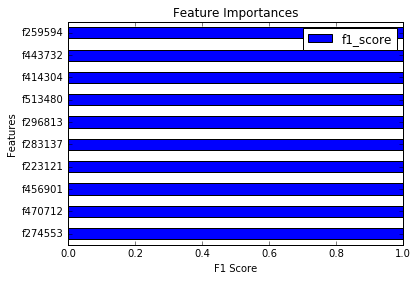

In [40]:
df = pd.DataFrame({'f1_score':model.get_fscore().values()}, 
                  index=model.get_fscore().keys())
df = df.sort('f1_score',ascending=True)
df[:10].plot(kind='barh')
plt.xlabel("F1 Score")
plt.ylabel("Features")
plt.title("Feature Importances")

In [32]:
model.get_fscore().values()

[3, 2, 1, 1, 2, 2, 2, 1]

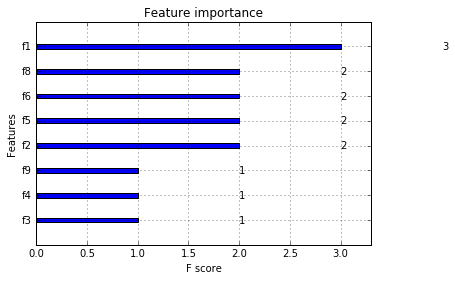

In [16]:
xgb.plot_importance(model)

In [65]:
model = xgb.XGBClassifier()
print model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [66]:
model.fit(X_train,y_train,eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [20]:
model.predict_proba(X_test)

array([[ 0.65184641,  0.34815356],
       [ 0.74603701,  0.25396299],
       [ 0.32435191,  0.67564809],
       ..., 
       [ 0.71962714,  0.28037286],
       [ 0.08567679,  0.91432321],
       [ 0.01836032,  0.98163968]], dtype=float32)

In [24]:
150/60.0

2.5

In [26]:
X_train.shape

(2000, 10)

In [73]:
def load_data(filename):
    '''
    Load data into a data frame for use in running model
    '''
    return pickle.load(open(filename, 'rb'))


def stem_tokens(tokens, stemmer):
    '''Stem the tokens.'''
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed


def OHStokenize(text):
    '''Tokenize & stem. Stems automatically for now.
    Leaving "stemmer" out of function call, so it works with TfidfVectorizer'''
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

###########################################################################
# tokenization code

def seperatePunct(incomingString):
    outstr = ''
    characters = set(['!','@','#','$',"%","^","&","*",":","\\",
                  "(",")","+","=","?","\'","\"",";","/",
                  "{","}","[","]","<",">","~","`","|"])

    for char in incomingString:
        if char in characters:
            outstr = outstr + ' ' + char + ' '
        else:
            outstr = outstr + char

    return outstr

def hasNumbers(inputString):
     return any(char.isdigit() for char in inputString)

def text_cleaner(wordList):
    '''
    INPUT: List of words to be tokenized
    OUTPUT: List of tokenized words
    '''

    tokenziedList = []

    for word in wordList:

        #remove these substrings from the word
        word = word.replace('[deleted]','')
        word = word.replace('&gt','')

        #if link, replace with linktag
        if 'http' in word:
            tokenziedList.append('LINK_TAG')
            continue

        #if reference to subreddit, replace with reddittag
        if '/r/' in word:
            tokenziedList.append('SUBREDDIT_TAG')
            continue

        #if reference to reddit user, replace with usertag
        if '/u/' in word:
            tokenziedList.append('USER_TAG')
            continue

        #if reference to twitter user, replace with usertag
        if '@' in word:
            tokenziedList.append('USER_TAG')
            continue

        #if number, replace with numtag
        #m8 is a word, 5'10" and 54-59, 56:48 are numbers
        if hasNumbers(word) and not any(char.isalpha() for char in word):
            tokenziedList.append('NUM_TAG')
            continue

        #seperate puncuations and add to tokenizedList
        newwords = seperatePunct(word).split(" ")
        tokenziedList.extend(newwords)

    return tokenziedList

def mytokenize(comment):
    '''
    Input: takes in a reddit comment as a str or unicode and tokenizes it
    Output: a tokenized list
    '''
    tokenizer = PunktSentenceTokenizer()
    sentenceList = tokenizer.tokenize(comment)
    wordList = []
    for sentence in sentenceList:
        wordList.extend(sentence.split(" "))

    return text_cleaner(wordList)

In [74]:
path = '../../data/labeledRedditComments2.p'
cvpath = '../../data/twitter_cross_val.csv'

df = pickle.load(open(path, 'rb'))
dfcv = pd.read_csv(cvpath)




In [75]:
#take a subset of the data for testing this code
randNums = np.random.randint(low=0,high=len(df.index),size=(200,1))
rowList = [int(row) for row in randNums]
dfsmall = df.ix[rowList,:]

In [76]:
nf = dfsmall
X = nf.body
y = nf.label

Xcv = dfcv['tweet_text'].values
ycv = dfcv['label'].values

In [83]:
vect = TfidfVectorizer(stop_words='english', decode_error='ignore',
                           tokenizer=OHStokenize)


# fit & transform comments matrix
tfidf_X = vect.fit_transform(X)
tfidf_Xcv = vect.transform(Xcv)

In [84]:
print tfidf_X.shape
print tfidf_Xcv.shape

(200, 1700)
(10000, 1700)


In [124]:
type(tfidf_X)

scipy.sparse.csr.csr_matrix

In [129]:
nr, nc = tfidf_Xcvd.shape
newarray = np.ones(shape=(1,nc))
newtfidf_Xcvd = np.vstack((tfidf_Xcvd,newarray))
newsparse = sparse.csr_matrix(newtfidf_Xcvd)

In [135]:
newsparse.shape

(10001, 1700)

In [136]:
ncv = np.ones(shape=(1, ))
ycvnew = np.concatenate((ycv,ncv))

In [137]:
ycvnew.shape

(10001,)

In [85]:
tfidf_Xcvd = tfidf_Xcv.todense()

In [108]:
sys.getsizeof(tfidf_Xcv.todense())

144

In [109]:
sys.getsizeof(tfidf_X)

64

In [130]:
xg_cv = xgb.DMatrix(tfidf_Xcv, label=ycv)
xg_train = xgb.DMatrix(tfidf_X, label=y)
xg_newsparse = xgb.DMatrix(newsparse , label=y)
xg_cvd = xgb.DMatrix(tfidf_Xcvd, label=ycv)
print xg_train.feature_types

None


In [131]:
print xg_train.num_col()
print xg_cv.num_col()
print xg_cvd.num_col()
print xg_newsparse.num_col()

1700
1696
1700
1700


In [88]:
param = {'max_depth':2,
             'eta':0.5,
             'silent':1,
             'objective':'binary:logistic',
             'eval_metric':'auc'
             }
num_round = 5
watchlist = [(xg_train, 'train'), (xg_cvd, 'eval')]
results = dict()

In [63]:
model = xgb.train(param,
                  xg_train,
                  num_round,
                  watchlist,
                  evals_result=results,
                  maximize=False,
                  verbose_eval=True)

[0]	train-auc:0.557143	eval-auc:0.499306
[1]	train-auc:0.632473	eval-auc:0.494721
[2]	train-auc:0.715275	eval-auc:0.488865
[3]	train-auc:0.74478	eval-auc:0.478342
[4]	train-auc:0.780549	eval-auc:0.5674


In [64]:
results


{'eval': {'auc': [0.499306, 0.494721, 0.488865, 0.478342, 0.5674]},
 'train': {'auc': [0.557143, 0.632473, 0.715275, 0.74478, 0.780549]}}

In [43]:
paramdict = {'max_depth':[3,6],'learning_rate':[0.1,0.2]}

gs = GridSearchCV(xgb.XGBClassifier,param_grid=paramdict, scoring='auc',n_jobs=-1)

In [46]:
df = pd.DataFrame?

In [49]:
labels = ['max_depth','eta','num_rounds','eval_reslts']
df = pd.DataFrame(columns=labels)

In [56]:
data = [[3,0.1,100,results],[3,0.1,100,results],[3,0.1,100,results]]

In [57]:
d = pd.DataFrame(data=data,columns=labels)

In [58]:
d

,max_depth,eta,num_rounds,eval_reslts
0,3,0.1,100,"{u'train': {u'auc': [0.557143, 0.632473, 0.715..."
1,3,0.1,100,"{u'train': {u'auc': [0.557143, 0.632473, 0.715..."
2,3,0.1,100,"{u'train': {u'auc': [0.557143, 0.632473, 0.715..."


In [89]:
evalSet = zip(tfidf_Xcv,ycv)

In [90]:
model = xgb.XGBClassifier(max_depth = 3,
                          n_estimators = 20,
                          learning_rate = 0.5)

In [92]:
model.fit(tfidf_X,y,eval_set = evalSet, eval_metric = 'auc')
# model.fit(tfidf_X,y)

# results = model.evals_result()

ValueError: bad input shape ()